In [ ]:
# pktSize = 1500
# main(flavour = "TcpLinuxReno", 
#      time = 200, 
#      noOfSource = 2, 
#      total_access_bandwidth = "120Mbps", 
#      RTT = "10ms",
#      bottleneck_bandwidth = "100Mbps", 
#      bottleneck_delay = "1ms", 
#      packetSize = pktSize, 
#      queueL = "2084p", 
#      rcvBuff = str(pktSize*10000),
#      sndBuff = str(pktSize*10000),
#      enableBottleneckTrace = 0
#      )

In [1]:
from matplotlib import pyplot as plt
import errno

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'figure.max_open_warning': 0})

import numpy as np
import os

import threading

In [2]:
def plot_cwnd_vs_time(noOfSources = 2, rtt = "10ms" , flavour= "TcpBbr"):
    
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    for i in range(noOfSources):
        cwndvstime = {}

        with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt}/{noOfSources}/cwndDropTail_{i}.txt", "r") as f:
            lines = f.readlines()
        
        for line in lines:
            split_line = line.split()
            cwndvstime[float(split_line[0])] = float(split_line[1]);

        plt.plot(cwndvstime.keys(), cwndvstime.values())
            
    plt.xlabel("time")
    plt.ylabel("cwnd")
    plt.title(f"Congestion windows size vs time     Sources:{noOfSources}    RTT:{rtt}    Flavour:{flavour}")
    f.close()

In [3]:
def plot_dropped_vs_time( noOfSources = 2, rtt = "10ms" , flavour= "TcpBbr"):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    
    droppedpvstime = {}
    
    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt}/{noOfSources}/droppedPacketTrace.txt", "r") as f:
        lines = f.readlines()
        prev = 0;
        total_dropped = 0;
        bin = 0;
        for line in lines:
            split_line = line.split()
            
            if ( float(split_line[0]) - prev < 0.1) :
                bin = bin+1;
            else:
                droppedpvstime[prev] = bin;
                prev = float(split_line[0]);
                bin = 0;

    
    plt.plot(droppedpvstime.keys(), droppedpvstime.values())
    
    plt.xlabel("time")
    plt.ylabel("Packet Dropped")
    plt.title(f"Packet Dropped vs time     Sources:{noOfSources}    RTT:{rtt}    Flavour:{flavour}")
    f.close()


In [4]:
def plot_qsize_vs_time( noOfSources = 2, rtt = "10ms" , flavour= "TcpBbr", maxQSize = "2084p"):
    f = plt.figure()
    f.set_figwidth(25)
    f.set_figheight(6)
    
    
    qutilvstime = {}

    with open(f"/mnt/Store/Project-summer/runtime/{flavour}/{rtt}/{noOfSources}/qsizeTrace.txt", "r") as f:
        lines = f.readlines()
    
    for line in lines:
        split_line = line.split()
        
        qutilvstime[float(split_line[0])] = (float(split_line[1])/float(maxQSize[:-1]))*100;

    
    plt.plot(qutilvstime.keys(), qutilvstime.values())
            
    plt.xlabel("time")
    plt.ylabel("Q utilization %")
    plt.title(f"Q utilization vs time     Sources:{noOfSources}    RTT:{rtt}    Flavour:{flavour}")
    f.close()


In [5]:
def clean(flavor = "default" , 
          time = 200 , 
          queueL = 5, 
          noOfSource = 4, 
          total_input_bandwidth = 2, bottleneck_bandwidth = 1, RTT = 10, recvWindow = 50):
    os.system("rm -rf {}_{}_{}".format(flavor, noOfSource, RTT));

In [6]:
def main(flavour = "TcpBbr" , time = 200 ,total_access_bandwidth = 120, bottleneck_bandwidth = 100, 
         bottleneck_delay = 1 , RTT = "10ms", packetSize = 1458, queueL = "5p", noOfSource = 2, 
         rcvBuff = 1458*10000, sndBuff = 1458*10000, enableBottleneckTrace = 0):
    
     # access_link_delay_val = RTT[0:-2]
     access_link_bandwidth_val = total_access_bandwidth[0:-4]
     
     #access_link_delay = str(float(access_link_delay_val)/4)+"ms"
     access_link_bandwidth = str(float(access_link_bandwidth_val)/noOfSource)+"Mbps"
     
     lock = threading.Lock();
     
     
     lock.acquire();   
    
     try: 
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT}")
               
          if os.path.exists(f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT}/{noOfSource}") == False:
               os.mkdir( f"/mnt/Store/Project-summer/runtime/{flavour}/{RTT}/{noOfSource}")
     except OSError as exc:
          if exc.errno != errno.EEXIST:
               raise
          pass
     
     lock.release();
    
     # if os.path.exists("/mnt/Store/Project-summer/runtime"):
     #     os.system("rm -rf /mnt/Store/Project-summer/runtime/*")
          
     cmd = f'''./ns3 run \"scratch/tcp_ftp_n --nSources={noOfSource} 
     --flavour={flavour} --bottleneckBandwidth={bottleneck_bandwidth} 
     --bottleneckDelay={bottleneck_delay} --accessBandwidth={access_link_bandwidth} 
     --queueSize={queueL} --pktSize={packetSize} 
     --simDuration={time} --rcvBuff={rcvBuff} --sndBuff={sndBuff} --enableBottleneckTrace={enableBottleneckTrace} 
     --RTT={RTT}\"'''
     
     #print(cmd)
     os.system(cmd)
     plot_cwnd_vs_time(noOfSource, RTT, flavour)
     plot_qsize_vs_time(noOfSource, RTT, flavour, queueL)
     plot_dropped_vs_time(noOfSource, RTT, flavour)
     #clean(flavor = flavor, time = time, queueL = queueL, noOfSource = noOfSource, total_input_bandwidth = total_input_bandwidth, bottleneck_bandwidth= bottleneck_bandwidth, RTT = RTT, recvWindow = recvWindow)   


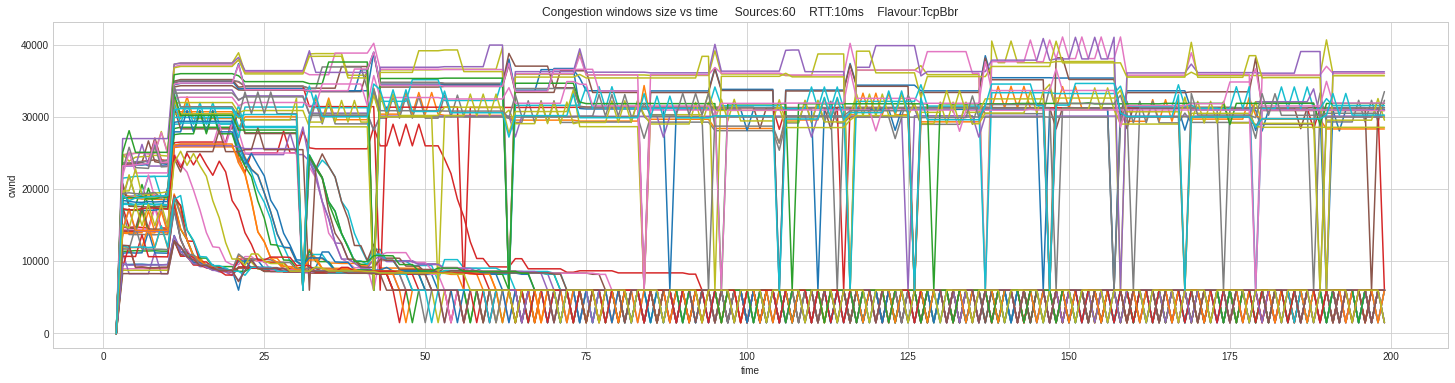

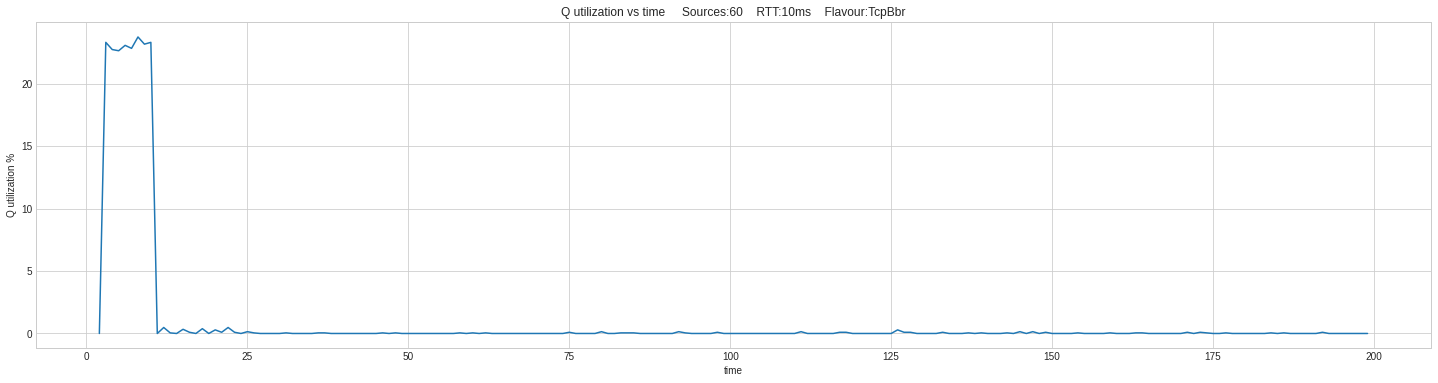

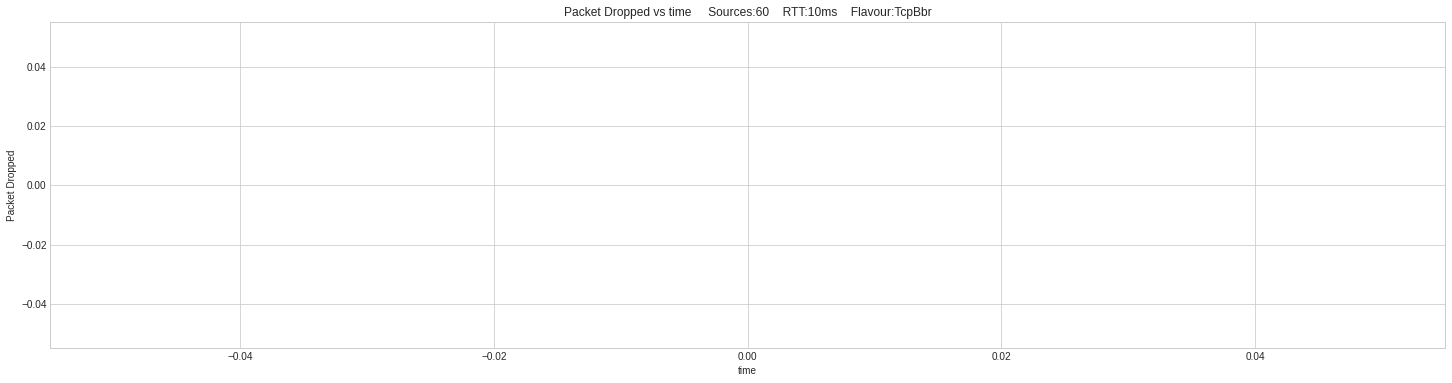

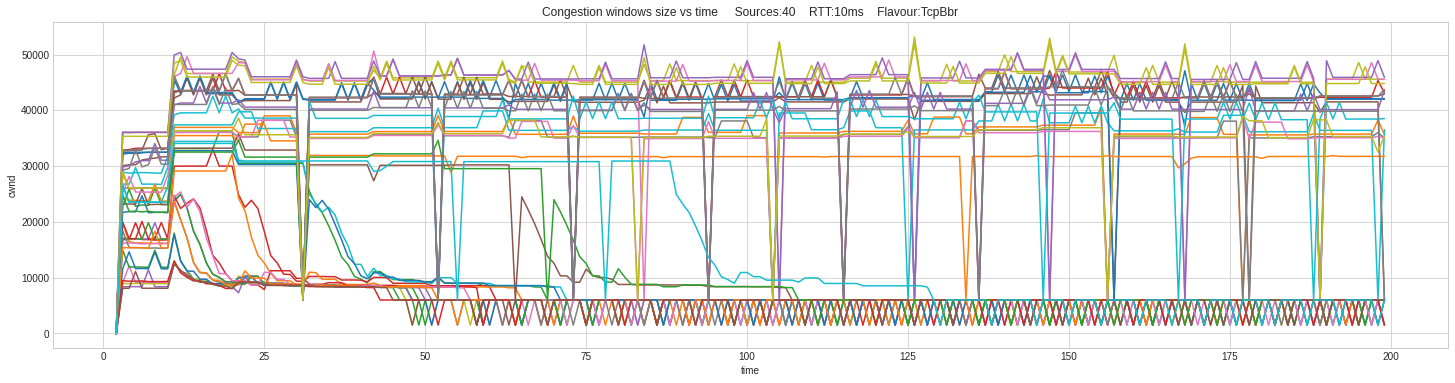

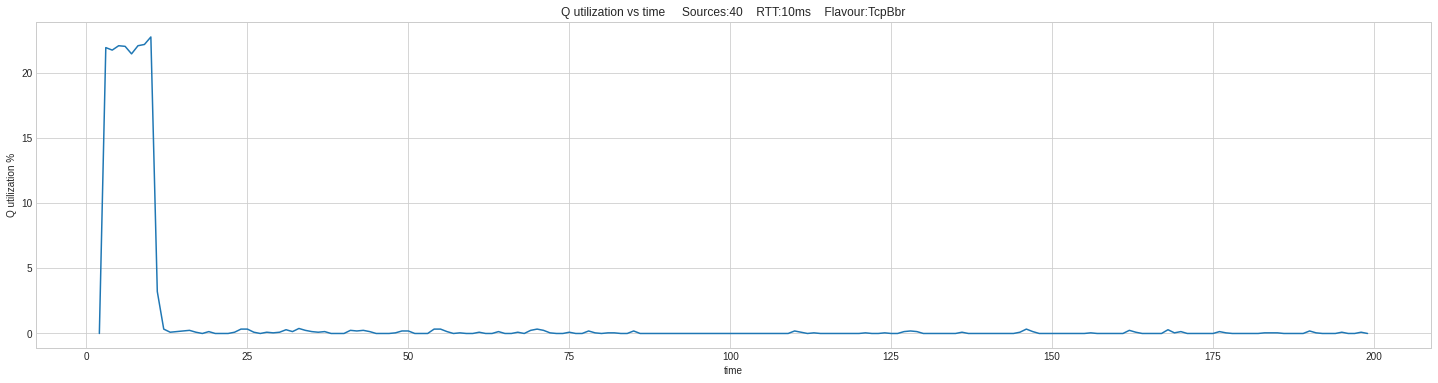

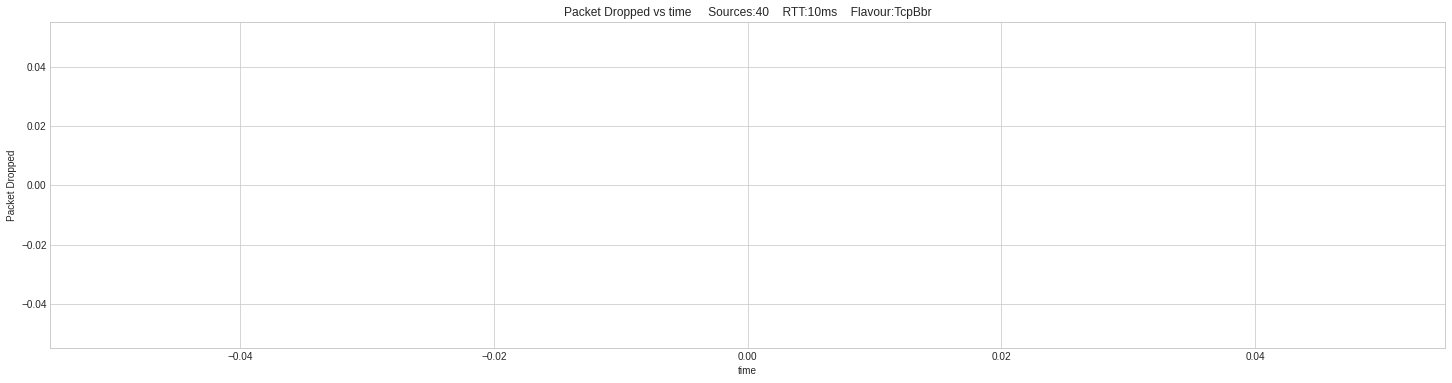

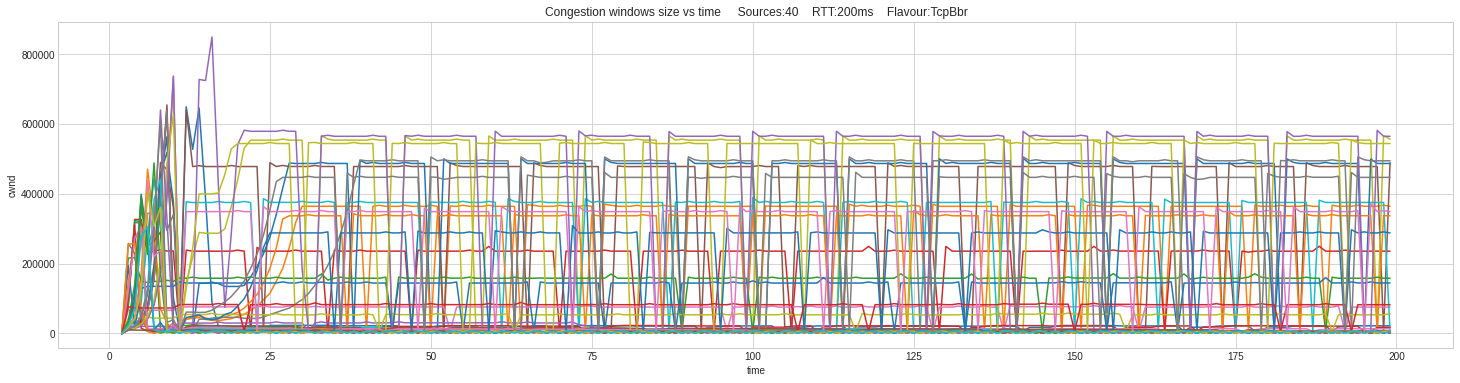

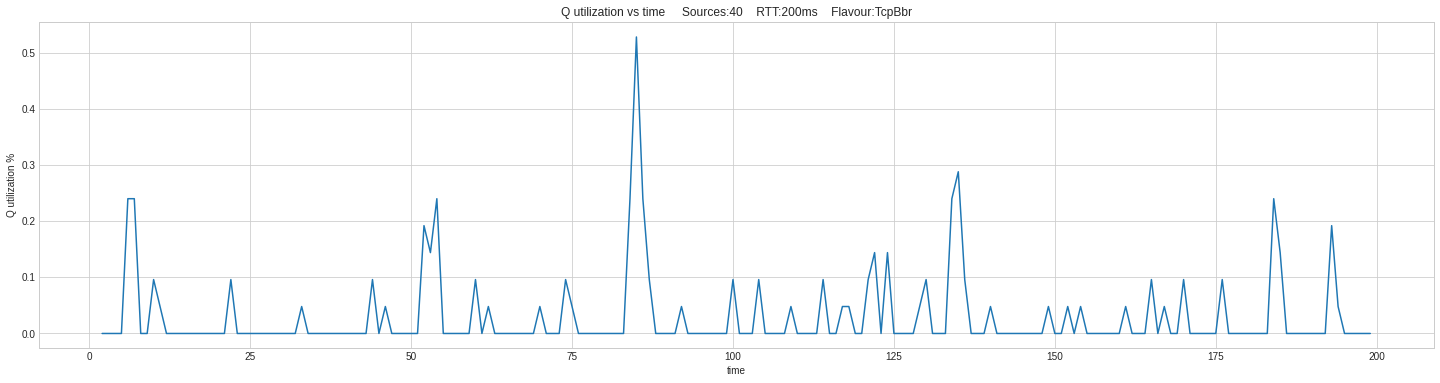

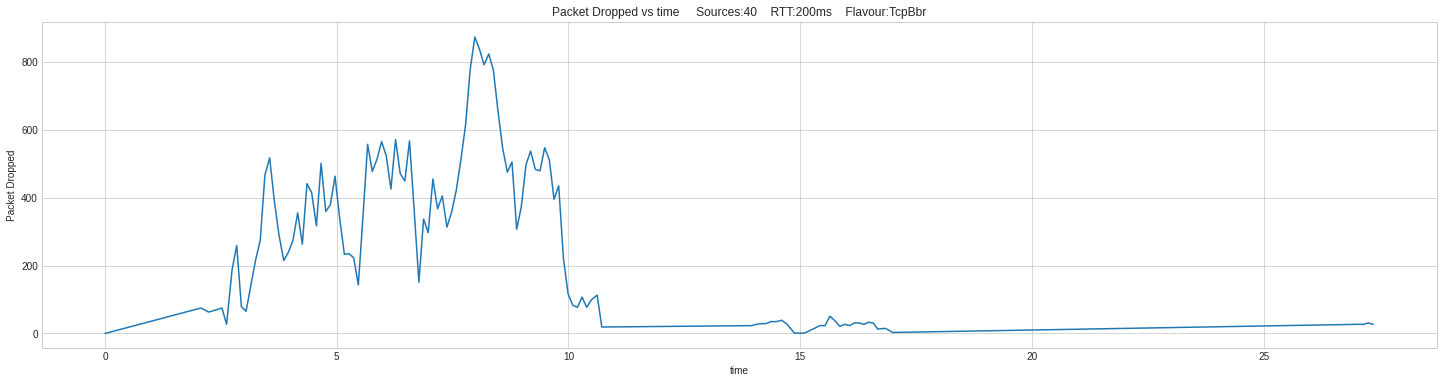

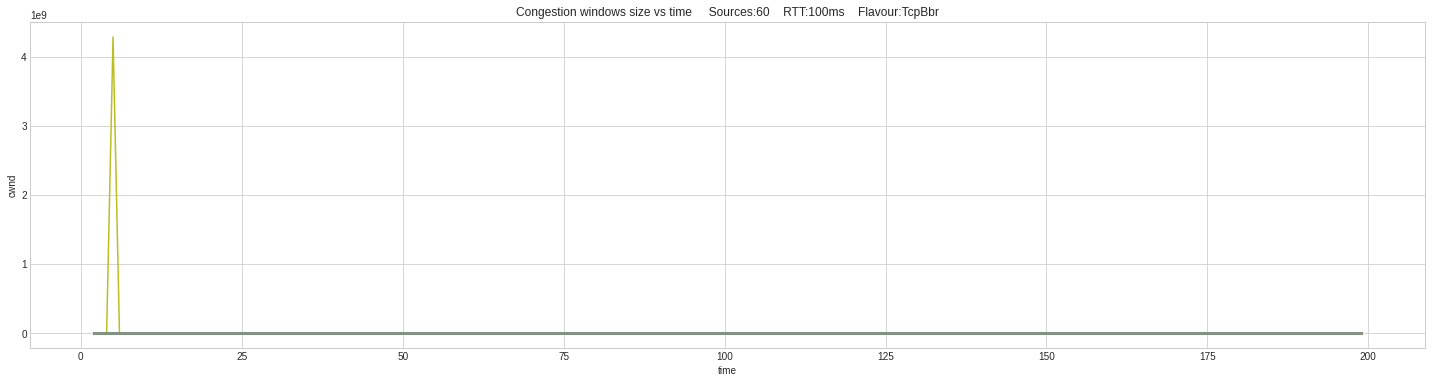

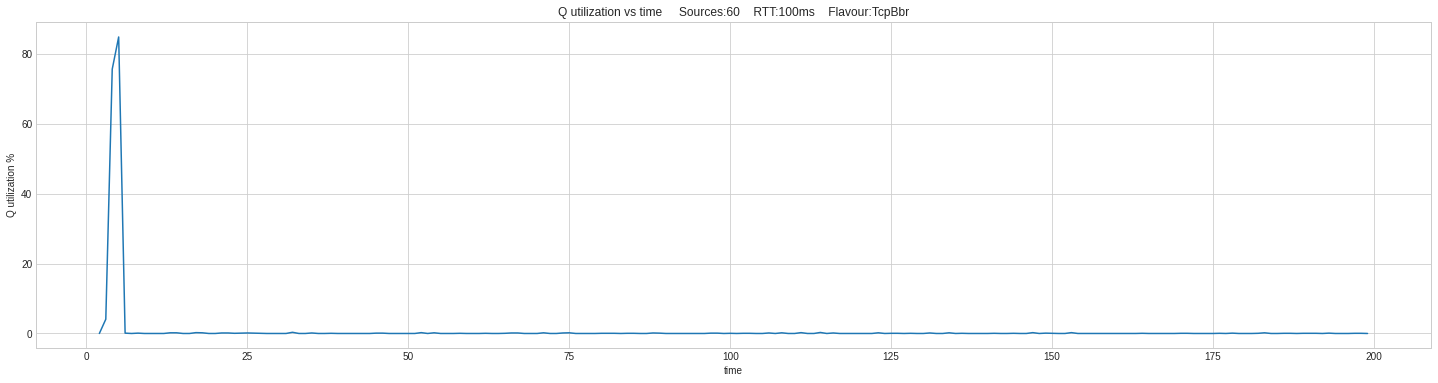

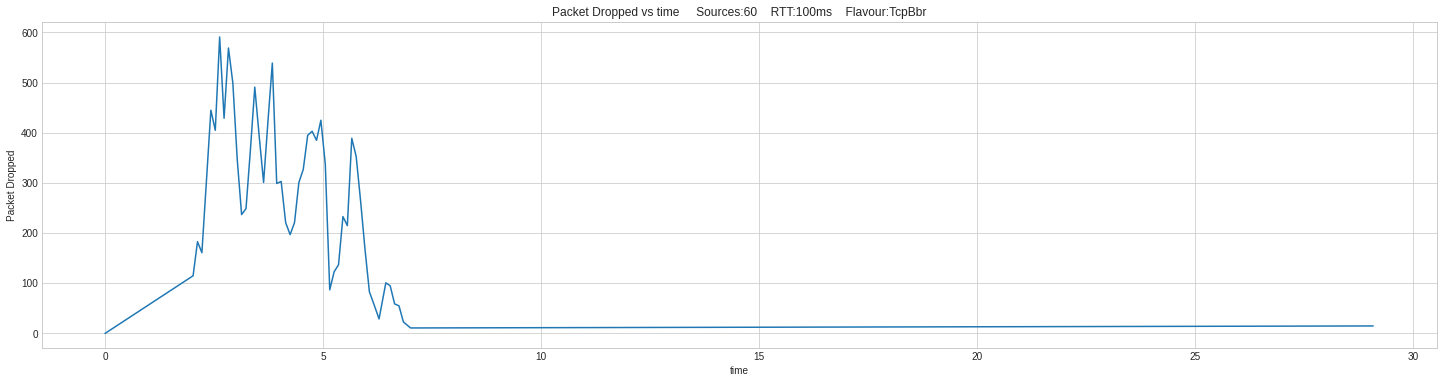

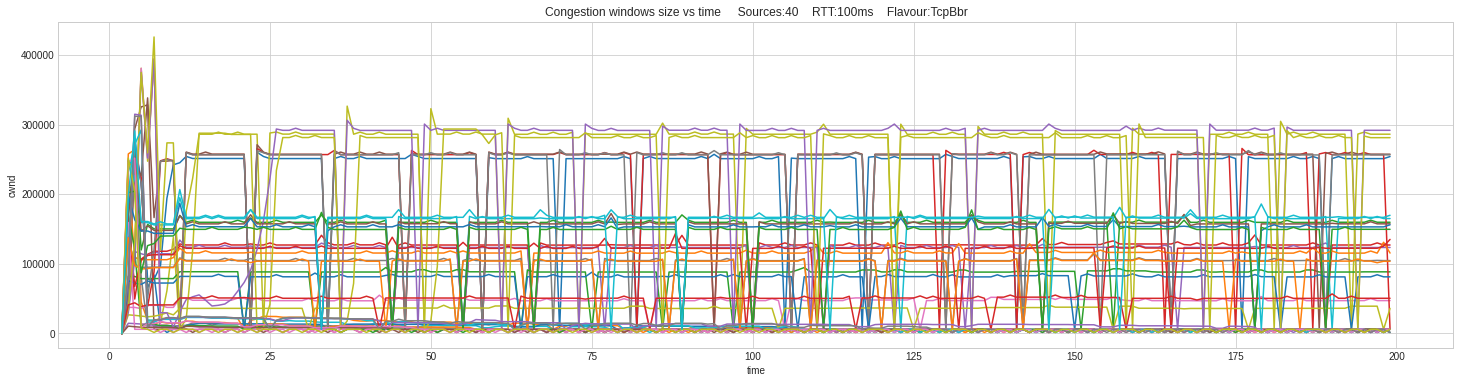

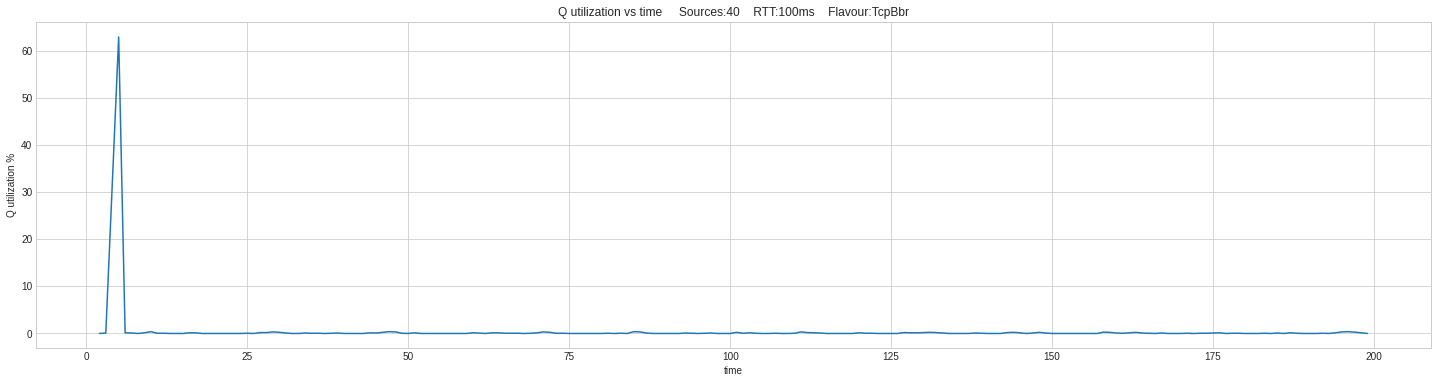

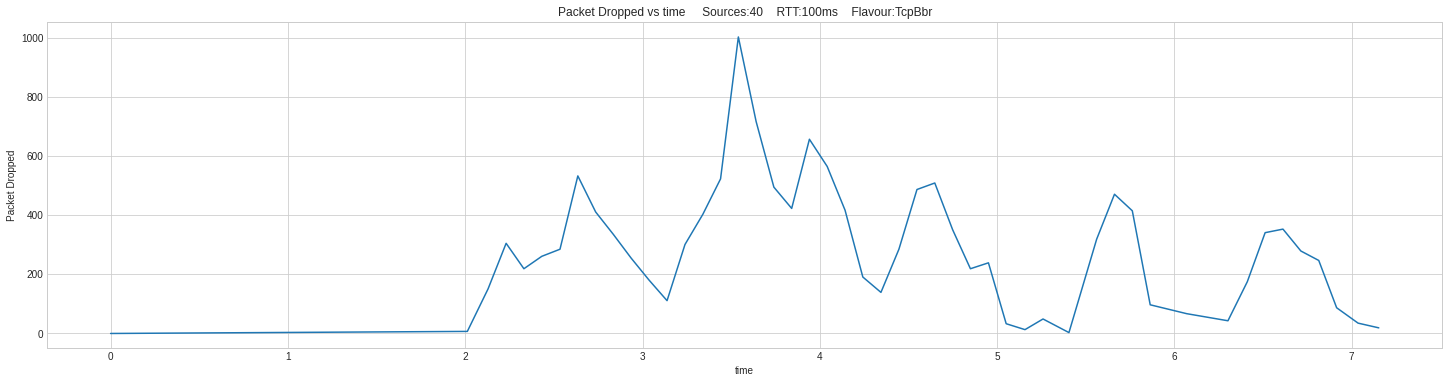

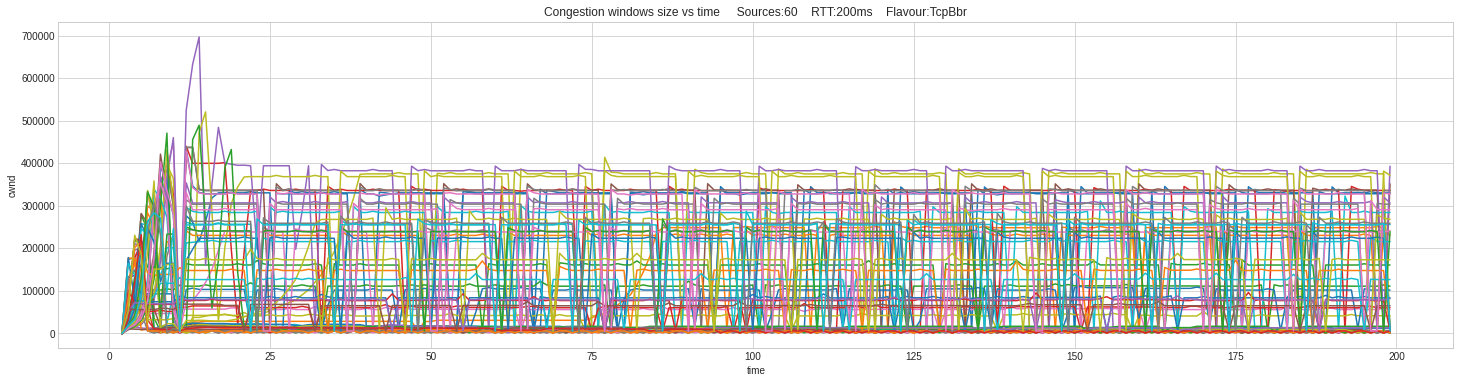

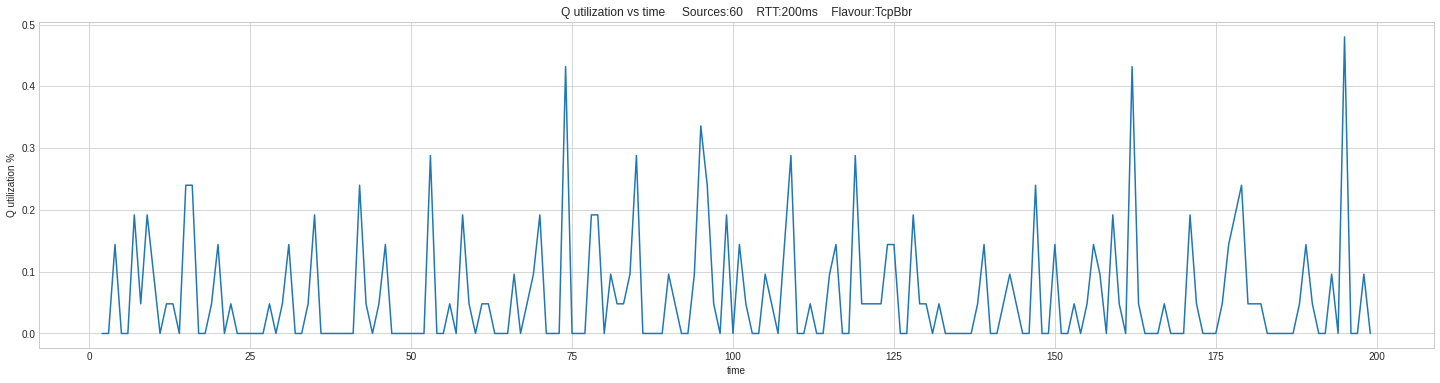

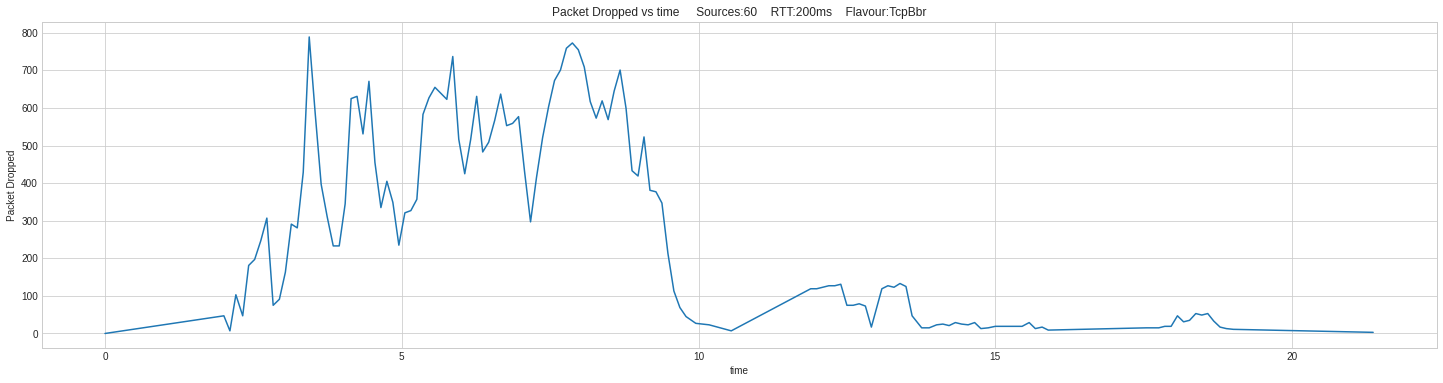

In [29]:
# Running multiple simulations
threads = []

pktSize = 1500
flavour = ["TcpBbr", "TcpNewReno"]  
RTTs = ["10ms", "100ms", "200ms"]
sources = [40, 60]


for rtt in RTTs:
    for s in sources:
        for flav in flavour:
            threads.append( threading.Thread ( target = main , args=(flav ,  200 , "120Mbps",  "100Mbps", "1ms" , rtt , pktSize,  "2084p", s, str(pktSize*10000), str(pktSize*10000), 0 )));
        
        
for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

-- GLOB mismatch!


-- Using default output directory /mnt/Store/Project-summer/ns-3-dev/build
-- Proceeding without cmake-format
-- find_external_library: SQLite3 was not found. Missing headers: "sqlite3.h" and missing libraries: "sqlite3".
-- SQLite was not found
-- Harfbuzz is required by GTK3 and was not found.
-- LibXML2 was not found. Continuing without it.
-- LibRT was found.
-- Bindings: python bindings disabled due to the following missing dependencies: cppyy
-- Visualizer requires Python bindings
-- Could NOT find Boost (missing: Boost_INCLUDE_DIR) 
-- GSL was not found. Continuing without it.
-- docs: doxygen documentation not enabled due to missing dependencies: doxygen;dot;dia
-- Failed to locate sphinx-build executable (missing: SPHINX_EXECUTABLE) 
-- docs: sphinx documentation not enabled due to missing dependencies: Sphinx;epstopdf;pdflatex;latexmk;dvipng
-- Precompiled headers were enabled
-- Processing src/antenna
-- Processing src/aodv
-- Processing src/applications
-- Processing src/br

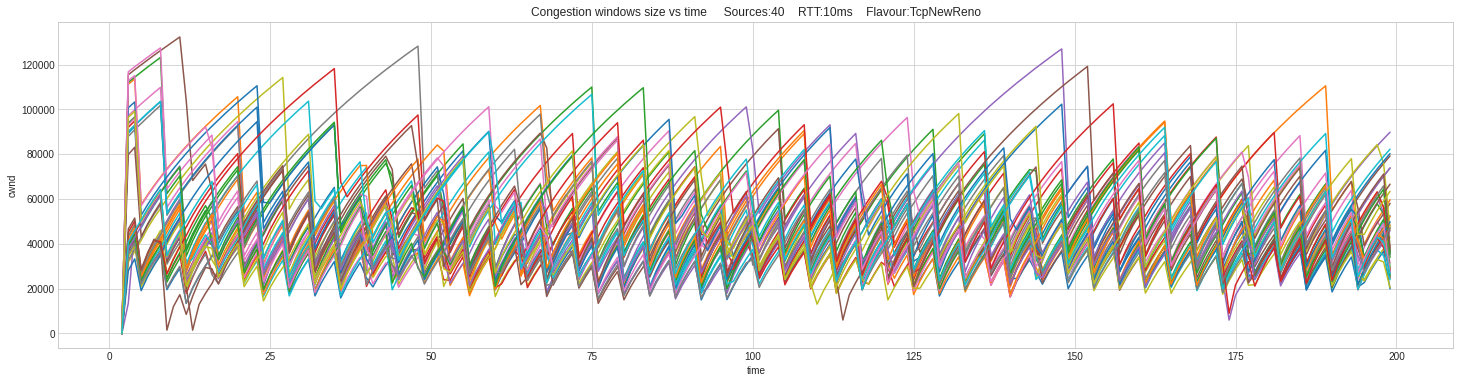

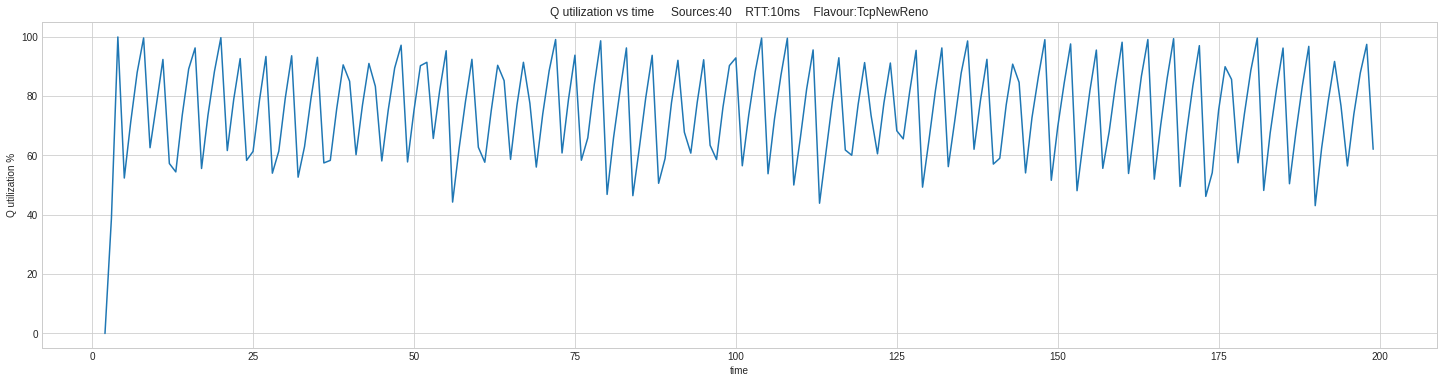

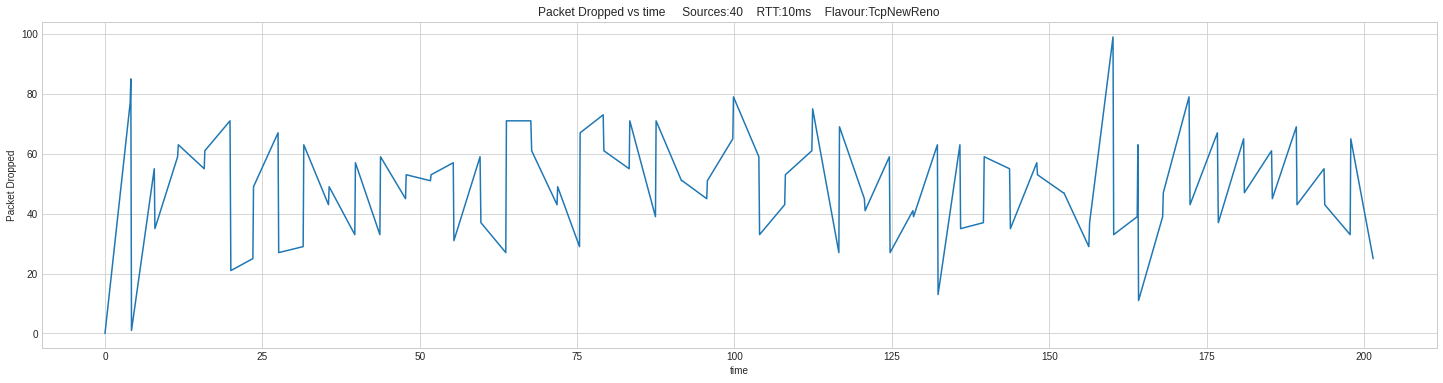

In [8]:
pktSize = 1500
main(flavour = "TcpNewReno", 
     time = 200, 
     noOfSource = 40, 
     total_access_bandwidth = "120Mbps", 
     RTT = "10ms",
     bottleneck_bandwidth = "100Mbps", 
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     rcvBuff = str(pktSize*10000),
     sndBuff = str(pktSize*10000),
     enableBottleneckTrace = 0
     )

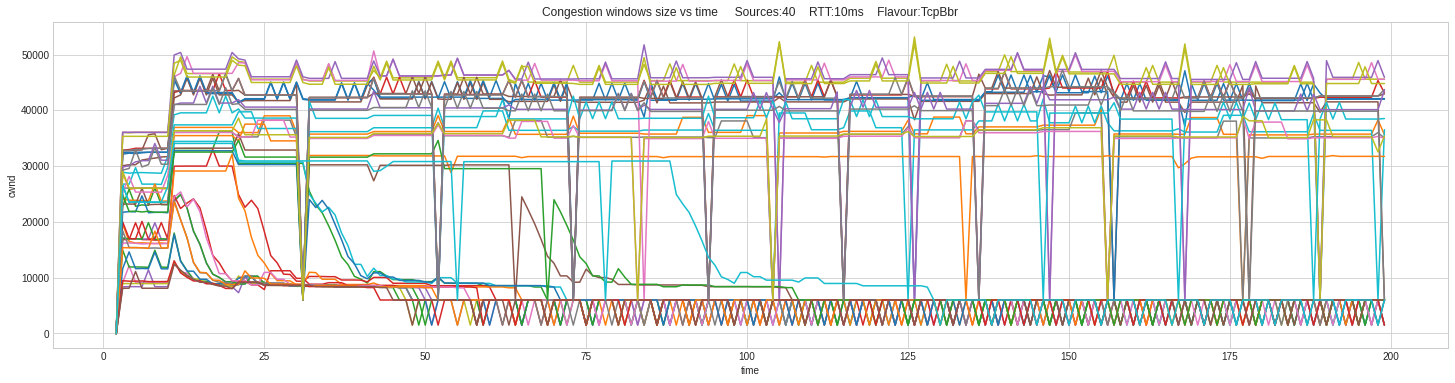

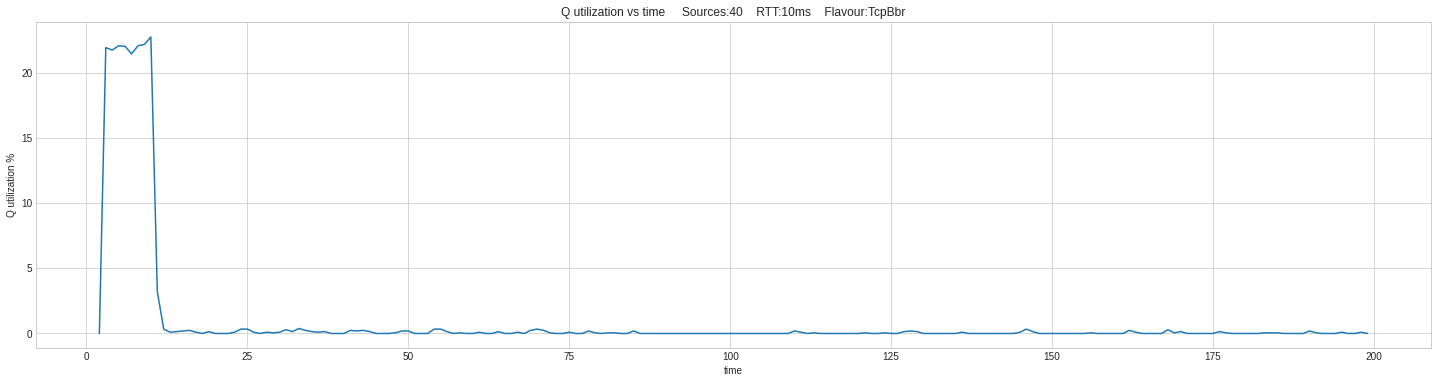

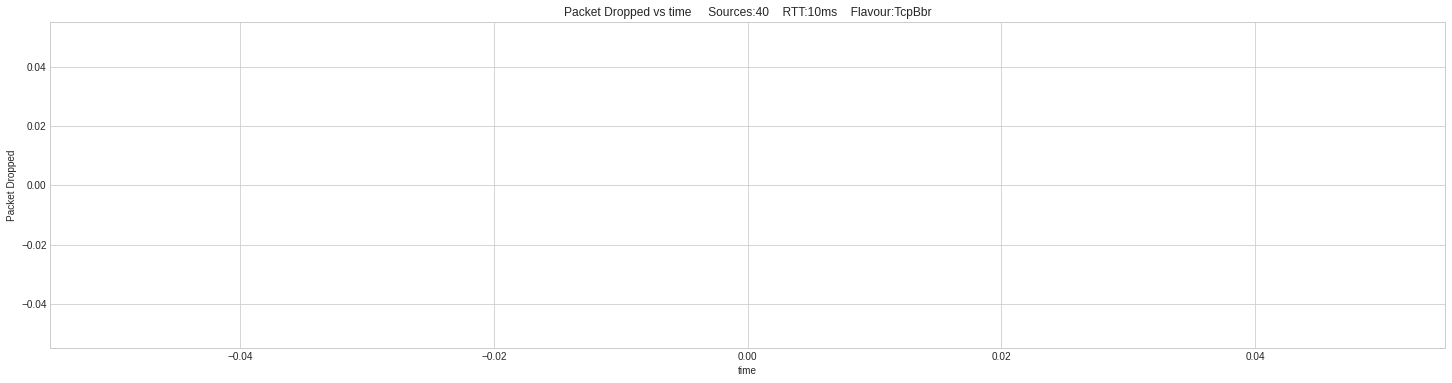

In [9]:
pktSize = 1500
main(flavour = "TcpBbr", 
     time = 200, 
     noOfSource = 40, 
     total_access_bandwidth = "120Mbps", 
     RTT = "10ms",
     bottleneck_bandwidth = "100Mbps", 
     bottleneck_delay = "1ms", 
     packetSize = pktSize, 
     queueL = "2084p", 
     rcvBuff = str(pktSize*10000),
     sndBuff = str(pktSize*10000),
     enableBottleneckTrace = 0
     )